## 神经网络解决多分类问题¶
## 案例： 手写数字识别
## 数据集：ex4data1.mat
## 初始参数：ex4weights.mat

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
data = sio.loadmat('ex4data1.mat')
raw_X = data['X']
raw_y = data['y']

In [3]:
X = np.insert(raw_X,0,values=1,axis=1)
X.shape

(5000, 401)

### 1. 对y进行独热编码处理：one-hot编码

In [4]:
def one_hot_encoder(raw_y):
    
    result = []
    
    for i in raw_y: # 1-10
        y_temp = np.zeros(10)
        y_temp[i-1] = 1 
        
        result.append(y_temp)
        
    return np.array(result)

In [5]:
y = one_hot_encoder(raw_y)

In [6]:
y.shape

(5000, 10)

In [7]:
theta = sio.loadmat('ex4weights.mat')

theta1, theta2 = theta['Theta1'],theta['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

### 2.序列化权重参数

In [8]:
def serialize(a,b):
    
    return np.append(a.flatten(),b.flatten())

In [9]:
theta_serialize = serialize(theta1,theta2)

In [10]:
theta_serialize.shape

(10285,)

### 3.解序列化权重参数

In [11]:
def deserialize(theta_serialize):
    theta1 = theta_serialize[:25*401].reshape(25,401)
    theta2 = theta_serialize[25*401:].reshape(10,26)
    return theta1,theta2

In [12]:
theta1,theta2 = deserialize(theta_serialize)

In [13]:
theta1.shape,theta2.shape

((25, 401), (10, 26))

### 4.前向传播

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [19]:
def feed_forward(theta_serialize,X):
    theta1,theta2 = deserialize(theta_serialize)
    
    a1 = X
    z2 = X@theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,values=1,axis=1)
    z3 = a2@theta2.T
    h = sigmoid(z3)#5000*10
    
    return a1,z2,a2,z3,h

### 5.损失函数
#### 5-1 不带正则化的损失函数

In [20]:
def cost(theta_serialize,X,y):
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h))/len(X)
    
    return J

In [21]:
cost(theta_serialize,X,y)

0.2876291651613189

### 6-2 带正则化的梯度

In [24]:
def reg_cost(theta_serialize,X,y,lamda):
    theta1,theta2 = deserialize(theta_serialize)
    sum1 = np.sum(np.power(theta1[:,1:],2))
    sum2 = np.sum(np.power(theta2[:,1:],2))
    reg = (sum1+sum2)*lamda/(2*len(X))
    
    return reg + cost(theta_serialize,X,y)

In [25]:
lamda = 1
reg_cost(theta_serialize,X,y,lamda)

0.38376985909092365

## 6.反向传播
### 6-1 无正则化的梯度

In [26]:
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [27]:
def gradient(theta_serialize,X,y):
    theta1,theta2 = deserialize(theta_serialize)
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    d3 = h-y
    d2 = d3 @ theta2[:,1:] * sigmoid_gradient(z2)
    D2 = (d3.T @ a2) / len(X)
    D1 = (d2.T @ a1) / len(X)
    return serialize(D1,D2)

### 6-2 带正则化的梯度

In [28]:
def reg_gradient(theta_serialize,X,y,lamda):
    D = gradient(theta_serialize,X,y)
    D1,D2 = deserialize(D)
    
    theta1,theta2 = deserialize(theta_serialize)
    D1[:,1:] = D1[:,1:]  + theta1[:,1:] * lamda / len(X)
    D2[:,1:] = D2[:,1:]  + theta2[:,1:] * lamda / len(X)
    
    return serialize(D1,D2)

## 7.神经网络优化

In [29]:
def nn_training(X,y):
    
    init_theta = np.random.uniform(-0.5,0.5,10285)
    res = minimize(fun =reg_cost,
                   x0 = init_theta,
                  args = (X,y,lamda),
                  method='TNC',
                  jac = reg_gradient,
                options = {'maxiter':300})
    
    return res

In [30]:
lamda=10
res = nn_training(X,y)

In [31]:
raw_y = data['y'].reshape(5000,)

In [35]:
_,_,_,_,h = feed_forward(res.x,X)
y_pred = np.argmax(h,axis=1) + 1
acc = np.mean(y_pred == raw_y)

acc

0.9414

## 8.可视化隐藏层

In [33]:
def plot_hidden_layer(theta):
    theta1,_ = deserialize(theta)
    hidden_layer = theta1[:,1:] # 25,400
    
    
    fig,ax = plt.subplots(ncols=5,nrows=5,figsize=(8,8),sharex=True,sharey=True)
    
    for r in range(5):
        for c in range(5):
            
            ax[r,c].imshow(hidden_layer[5 * r + c].reshape(20,20).T,cmap='gray_r')
            
    
    plt.xticks([])
    plt.yticks([])
    
    plt.show

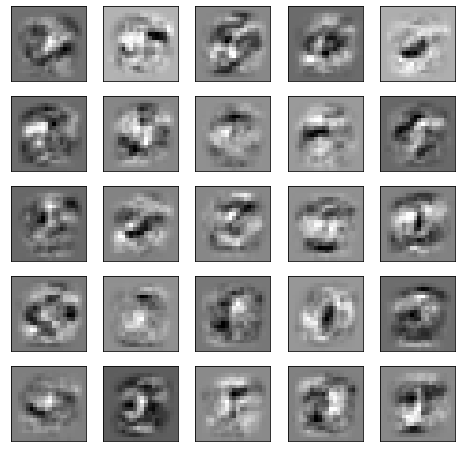

In [34]:
plot_hidden_layer(res.x)